# 2020-07-01 A coding and learning from binary inputs.ipynb

**Summary:** At different trials of an experiment, we observe some spikes or not on the different synapses of a neuron. We consider that this binary variable ("spiking?") is a Bernoulli trial with some given bias. Can we learn to retrieve a pattern of biases as a function of the address of the synapses? Can we do that when there are different possible patterns? 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%load_ext watermark
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
#np.set_printoptions(precision=2, suppress=True)
#%watermark -i -h -m -v -p numpy,matplotlib,tqdm  -r -g -b

## Detecting a pattern in a binary vector
Let's imagine a simple output of a layer and that it's binarized. If all synapses are iid:

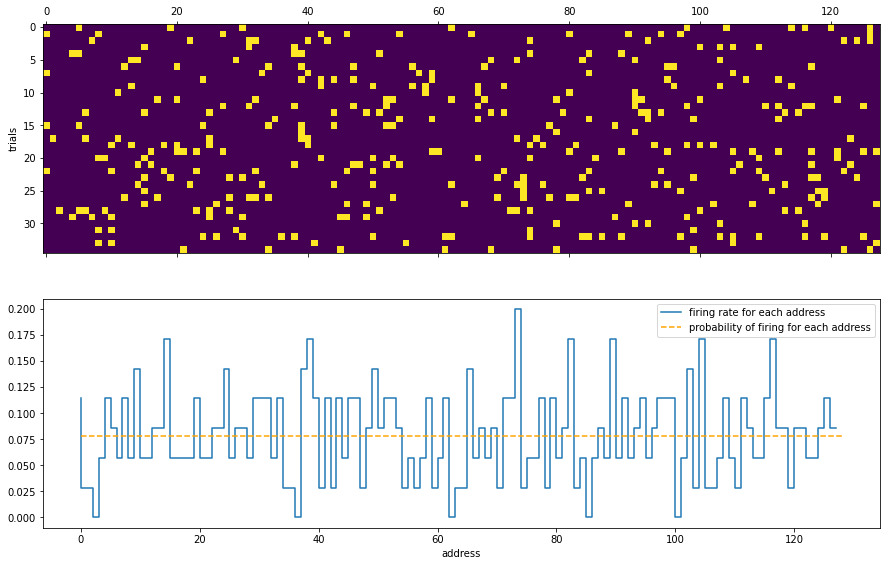

In [3]:
fig_width = 15
phi = np.sqrt(5)/2 + 1/2
l0, N = 10, 128
N_trials = 35
p1 = l0/N # probability of firing
noise = 1

b = np.random.rand(N_trials, N) < p1 # p0 is the prior 

fig, ax = plt.subplots(2, 1, figsize=(fig_width, fig_width/phi))
ax[0].matshow(b)
ax[0].set_ylabel('trials')
ax[1].step(np.arange(N), b.mean(axis=0), label='firing rate for each address')
ax[1].hlines(p1, 0, N, linestyles='--', color='orange', label='probability of firing for each address')
ax[1].set_xlabel('address')
plt.legend()
plt.show()

but in the general case, there is a tendency, such that some synapses are more activated than others. For instance:

Shape of b: 35 (trials) - 128 (addresses)


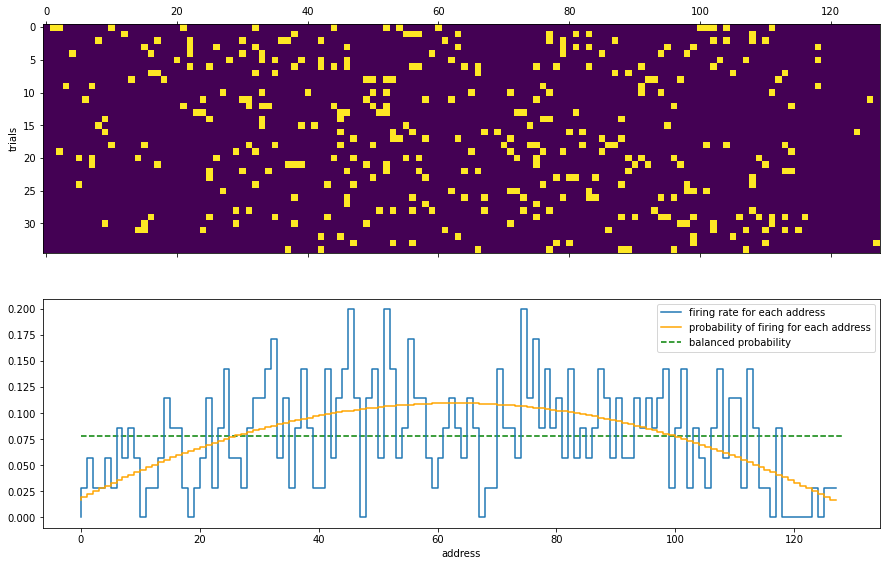

In [3]:
# define pattern
p_ = 1. - .85*np.linspace(-1, 1, N, endpoint=True)**2
p_ /= p_.mean()
p_ *= p1

# generate events
# N gives the number of addresses, N_trials the number of trials
from obv1 import generative_model
b = generative_model(p_, N_trials)
print(f'Shape of b: {b.shape[0]} (trials) - {b.shape[1]} (addresses)')

# plot
fig, ax = plt.subplots(2, 1, figsize=(fig_width, fig_width/phi))
ax[0].matshow(b)
ax[0].set_ylabel('trials')
ax[1].step(np.arange(N), b.mean(axis=0), label='firing rate for each address')
ax[1].step(np.arange(N), p_, color = 'orange', label = 'probability of firing for each address')
ax[1].hlines(p1, 0, N, color = 'green', linestyles='--', label='balanced probability')
ax[1].set_xlabel('address')
plt.legend()
plt.show()

- "Entropy is the number of bits required to transmit a randomly selected event from a probability distribution. A skewed distribution has low entropy, whereas a distribution where events have equal probability has a larger entropy. In information theory, we like to describe the “surprise” of an event. Low probability events are more surprising therefore have a larger amount of information. Whereas probability distributions where the events are equally likely are more surprising and have larger entropy."

- http://ilab.usc.edu/surprise/
- https://plus.maths.org/content/information-surprise

- Surprise is defined here in the sense of the entropy metric described by Shannon. It is then related to the Negative Log Likelihood (NLL), for a good (generative) model it is what you want to minimize -> maximize the likelihood. 

- For each trial, one can compute the surprise of the events for the 2 hypothesis (uniform vs non-uniform over synapses):

In [4]:
from obv1 import surprise_1D
s_flat = surprise_1D(b, p1)
s_p = surprise_1D(b, p_)
print('Mean Surprise for flat=', '%.3f' % s_flat.mean(), ', for non-flat =', '%.3f' % s_p.mean())

Mean Surprise for flat= 0.392 , for non-flat = 0.386


An information which is brought over all synapses : 

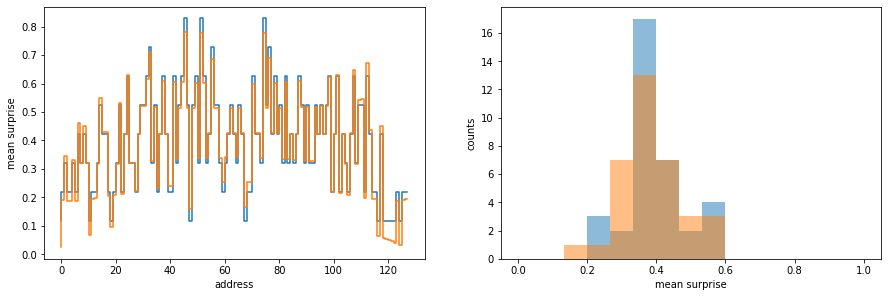

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(fig_width, fig_width/(2*phi)))
ax[0].step(np.arange(N), s_flat.mean(axis=0))
ax[0].step(np.arange(N), s_p.mean(axis=0))
ax[0].set_ylabel('mean surprise')
ax[0].set_xlabel('address')

bins = np.linspace(0, 1, 16, endpoint=True)
ax[1].hist(s_flat.mean(axis=1), bins=bins, alpha=.5)
ax[1].hist(s_p.mean(axis=1), bins=bins, alpha=.5)
ax[1].set_xlabel('mean surprise')
ax[1].set_ylabel('counts')
plt.show()

seems weak, but still allows to make a classification on a trial-by-trial basis:

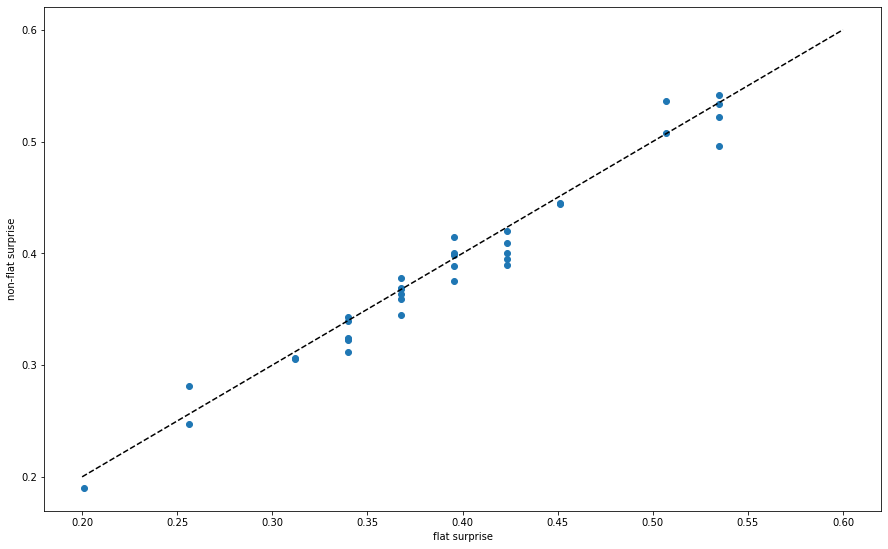

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
bins = np.linspace(0, 1, 16, endpoint=True)
ax.scatter(s_flat.mean(axis=1), s_p.mean(axis=1))
ax.plot([.2, .6], [.2, .6], 'k--')
ax.set_xlabel('flat surprise')
ax.set_ylabel('non-flat surprise')
plt.show()

The surprise for the flat distribution is higher than for the non-flat distribution, then the model given by the non-flat definition describes better the data. 

It's a measure which allows to classify one hypothesis with respect to another:

In [7]:
print('Proportion when surprise is correct',  '%.3f %%' % ((s_flat.mean(axis=1)>s_p.mean(axis=1)).mean()*100))

Proportion when surprise is correct 68.571 %


Then, validate the non-flat hypothesis over the flat one

## More than 2 hypothesis
It can be extended to the case with more than one hypothesis

In [8]:
from obv1 import stack

No handles with labels found to put in legend.


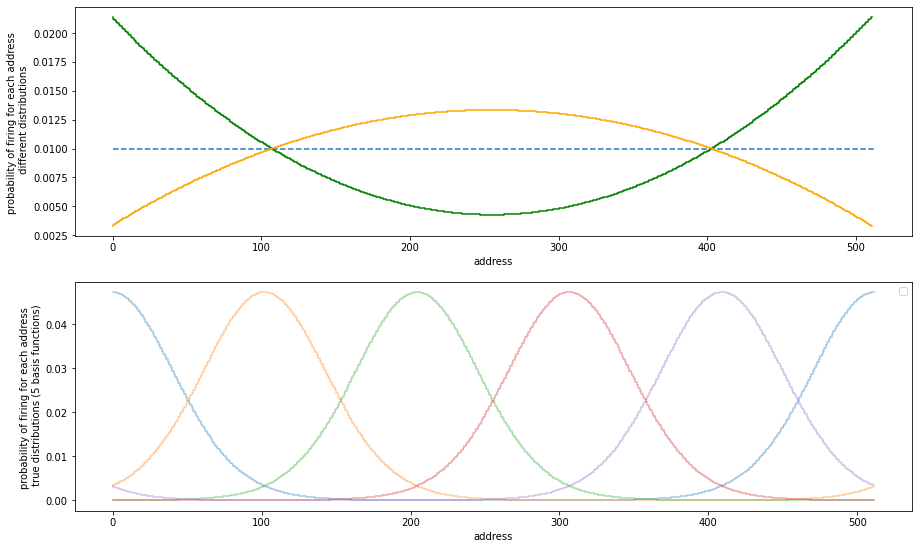

In [9]:
N_trials = 2**11 # number of trials
p1 = .01 # average firing probability
N = 2**9 # number of addresses
K = 5 # number of patterns
sigma = .51 # bandwidth

p2 = 1. - .75*np.linspace(-1, 1, N, endpoint=True)**2
p2 /= p2.mean()
p2 *= p1
p3 = 1. + 4.*np.linspace(-1, 1, N, endpoint=True)**2
p3 /= p3.mean()
p3 *= p1
p = np.vstack((p1*np.ones(N), p2, p3)).T

p_true = stack(K, N, sigma, p1)

N_hyp = p_true.shape[-1]
fig, ax = plt.subplots(2, 1, figsize=(fig_width, fig_width/phi))
#ax[0].step(np.arange(N), b.mean(axis=0), label='firing rate for each address')
ax[0].step(np.arange(N), p3, color = 'green', label = 'p3')
ax[0].step(np.arange(N), p2, color = 'orange', label = 'p2')
ax[0].hlines(p1, 0, N, linestyles='--', label='p1')
ax[0].set_xlabel('address')
ax[0].set_ylabel('probability of firing for each address \n different distributions')
for i_test in range(N_hyp):
    ax[1].step(np.arange(N), p_true[:, i_test], alpha=.4)
ax[1].set_ylabel('probability of firing for each address \n true distributions (5 basis functions)')
ax[1].set_xlabel('address')
plt.legend()
plt.show()

In [10]:
from obv1 import surprise
b = generative_model(p_true[:, 2], N_trials)
surp = surprise(b, p)
print('size of probas', p_true.shape, ', size of surprise', surp.shape)

size of probas (512, 5) , size of surprise (2048, 3)


Let's perform the same computations to classify the patterns *knowing their shape*:

In [11]:
K = p_true.shape[-1]
confusion_matrix = np.zeros((K, K))
F_true = []
for i_test in range(K):
    b = generative_model(p_true[:, i_test], N_trials)
    # matching
    S = surprise(b, p_true)
    k_star = S.argmin(axis=-1)
    F_true.append(S[range(N_trials), k_star].mean()) # average surprise *knowing* our selection
    for i_hyp in range(K):
        confusion_matrix[i_test, i_hyp] = (k_star == i_hyp).mean()
              
# average surprise of our detector once detection is done
F_true = np.mean(F_true)
print(f'Average surprise of our detector once detection is done: {F_true}')

Average surprise of our detector once detection is done: 0.0659617204177822


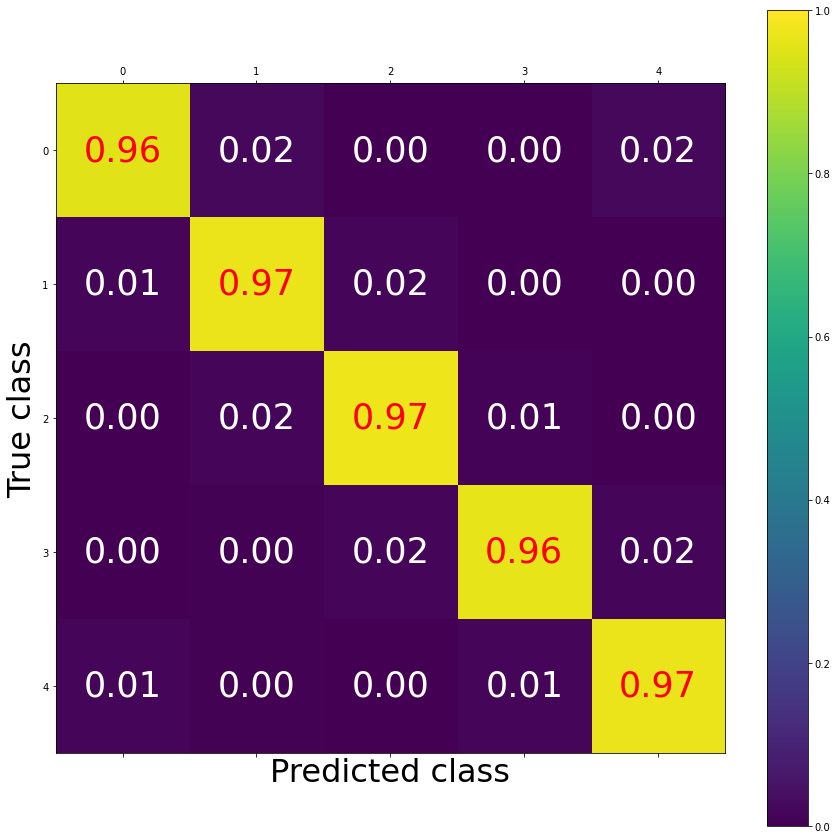

In [12]:
from obv1 import plot_confusion_matrix
fig, ax = plot_confusion_matrix(confusion_matrix)
plt.show()

## Now the magic: is there any way we can learn the patterns

Let's now suppose that we know there are 5 classes, but we do not know their shape. Let's learn them in a self-supervised manner.

First, we define some data with more classes:

size of data =  (10260, 512)


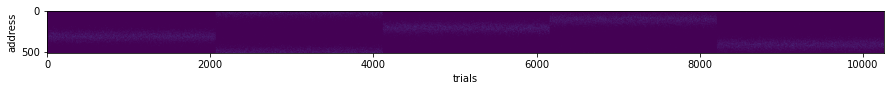

In [13]:
from obv1 import get_data

K = 5
p1 = 0.01

p_true = stack(K, N, sigma, p1)

b = get_data(p_true, N_trials)

print('size of data = ', b.shape)
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.imshow(b.T)
ax.set_xlabel('trials')
ax.set_ylabel('address')
plt.show()

We shuffle the trials independenptly

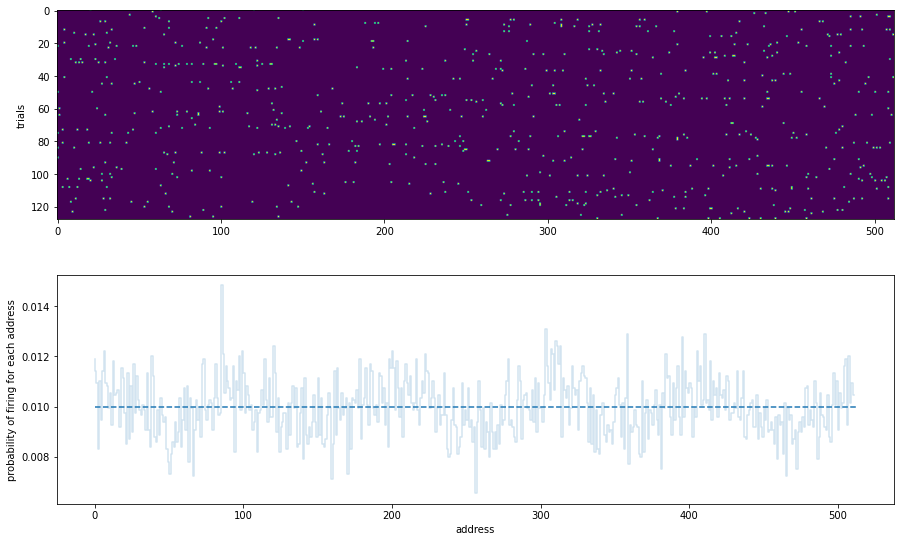

In [14]:
b = b[np.random.permutation(N_hyp*N_trials), :]
fig, ax = plt.subplots(2, 1, figsize=(fig_width, fig_width/phi))
ax[0].imshow(b[:128, :])
ax[0].set_ylabel('trials')
ax[1].step(np.arange(N), b.mean(axis=0), alpha=.2)
ax[1].hlines(p1, 0, N, linestyles='--')
ax[1].set_ylabel('probability of firing for each address')
ax[1].set_xlabel('address')
plt.show()

Let's initialize our probabilities to some flat distributions:

In [40]:
p_hat = np.ones((N, N_hyp))
for i_test in range(N_hyp):
    p_hat[:, i_test] *= b.mean(axis=0)
    p_hat[:, i_test] *= 1 + 1.*np.random.rand(N)
    p_hat[:, i_test] *= p1  / p_hat[:, i_test].mean()

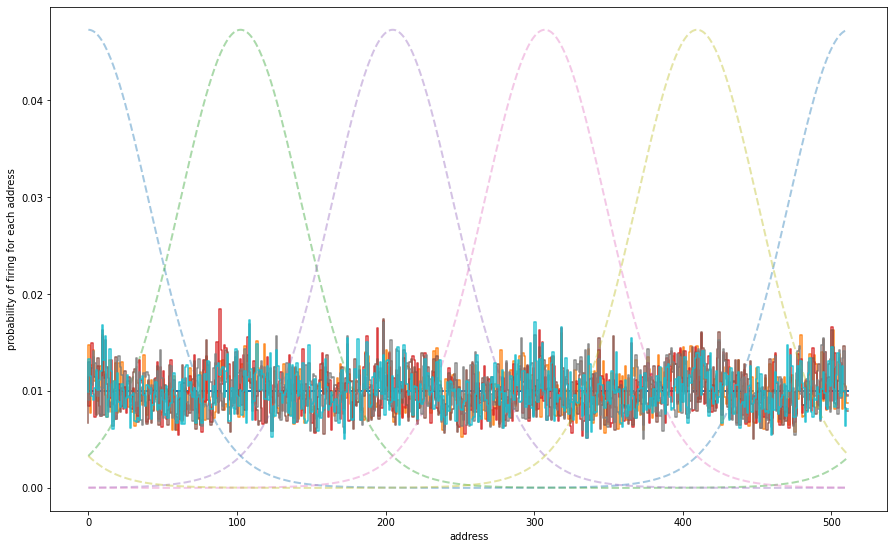

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
for i_test in range(N_hyp):
    ax.plot(np.arange(N), p_true[:, i_test], '--', alpha=.4, lw=2)
    ax.step(np.arange(N), p_hat[:, i_test], alpha=.9)
    ax.hlines(p1, 0, N, linestyles='--')

ax.set_ylabel('probability of firing for each address')
ax.set_xlabel('address')
plt.show()

We can now do a classical learning:

1. infer the most likely classes assuming the patterns are exact
2. update patterns assuming the classes we inferred were correct

In [ ]:
def get_data(p_true) :
    N, N_hyp = p_true.shape
    b = np.zeros((0, N))
    for i_test in range(K) :
        b = np.vstack((b, generative_model(p_true[:, i_test], n_trials)))
    return b

def get_data(p_true, N_trials, do_warmup = True, do_shuffle=True):
    N, K = p_true.shape
    if do_warmup :
        b = generative_model(p_true.mean() * np.ones(N), N_trials//100)
    else :
        b = np.zeros((0, N))
    order = np.arange(K)
    if do_shuffle: np.random.shuffle(order)
    for k in order:
        b = np.vstack((b, generative_model(p_true[:,k], N_trials)))
    return b

In [41]:
from obv1 import get_data

N_epochs = 500 
eta = .1
F = []
n_trials = N_trials
n = N

for i_epoch in trange(N_epochs) :
    # draw samples
    b = get_data(p_true, N_trials, do_warmup = False, do_shuffle=False)
    # matching by finding for each trials the indices which correspond to the minimal surprise
    
    s = surprise(b, p_hat) 
    k_star = s.argmin(axis = -1)
    F.append(s[range(n_trials * N_hyp), k_star].mean()) # average surprise *knowing* our selection
    
    eta_ = eta/(np.log(i_epoch+1)+1) # scheduling weight decay
    
    for k in range(N_hyp) :
        # frequency that pattern number *k* was selected
        proba_win = (k_star == k).sum() / n
        eta__ = eta_*proba_win
        
        # observed pattern on the trials for which we selected number *k*
        p_new = b[k_star == k, :].sum(axis = 0)
        p_new *= p1 / p_new.mean()
        
        # hebbian learning / moving average
        p_hat[:, k] = (1 - eta__) * p_hat[:,k] + eta__ * p_new
        
    # normalize
    # p_hat[:, i_test] *= p1  / p_hat[:, i_test].mean()

  0%|          | 0/100 [00:00<?, ?it/s]

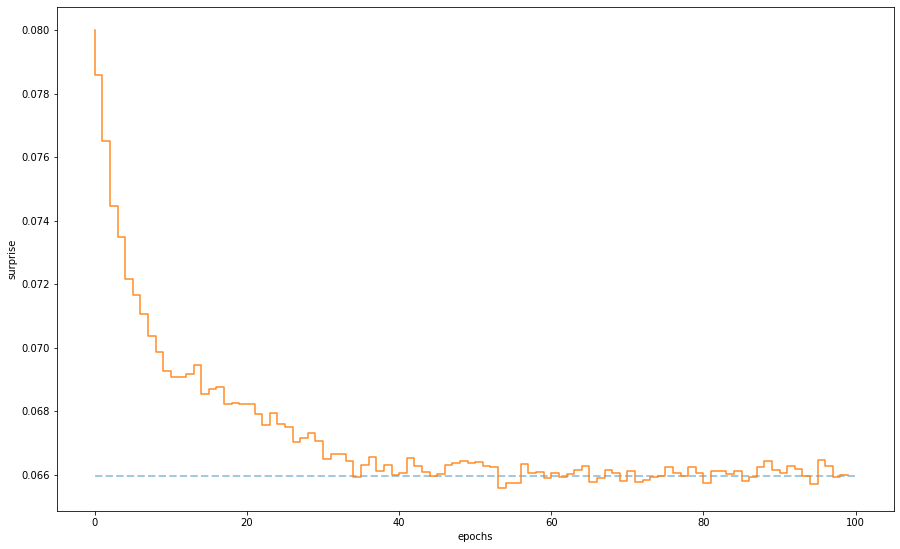

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot([0, N_epochs], [F_true, F_true], '--', alpha=.4, lw=2)
ax.step(np.arange(N_epochs), F, alpha=.9)
ax.set_ylabel('surprise')
ax.set_xlabel('epochs')
plt.show()

argmax values for p_hat: 308 and p_true: 0
argmax values for p_hat: 404 and p_true: 102
argmax values for p_hat: 213 and p_true: 205
argmax values for p_hat: 1 and p_true: 307
argmax values for p_hat: 106 and p_true: 410


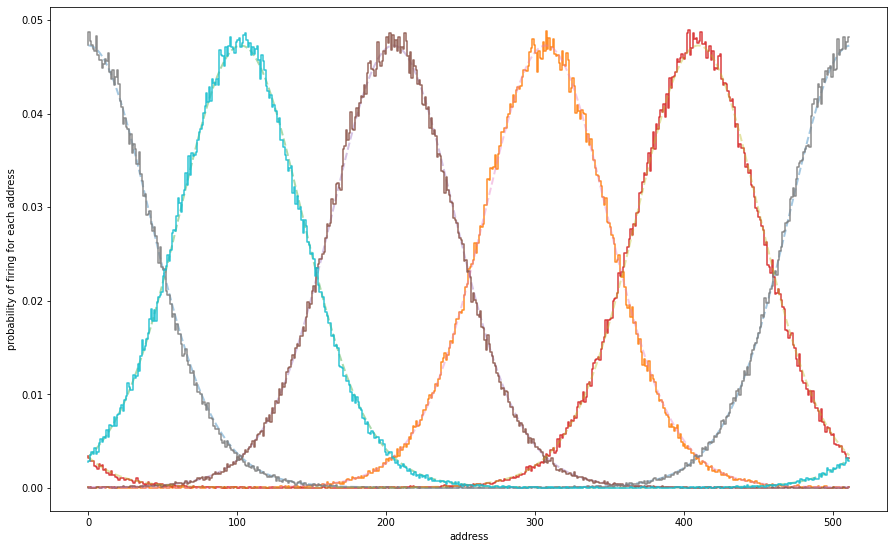

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
for i_test in range(N_hyp):
    ax.plot(np.arange(N), p_true[:, i_test], '--', alpha=.4, lw=2)
    ax.step(np.arange(N), p_hat[:, i_test], alpha=.9)
    print(f'argmax values for p_hat: {np.argmax(p_hat[:, i_test])} and p_true: {np.argmax(p_true[:, i_test])}')
ax.set_ylabel('probability of firing for each address')
ax.set_xlabel('address')
plt.show()

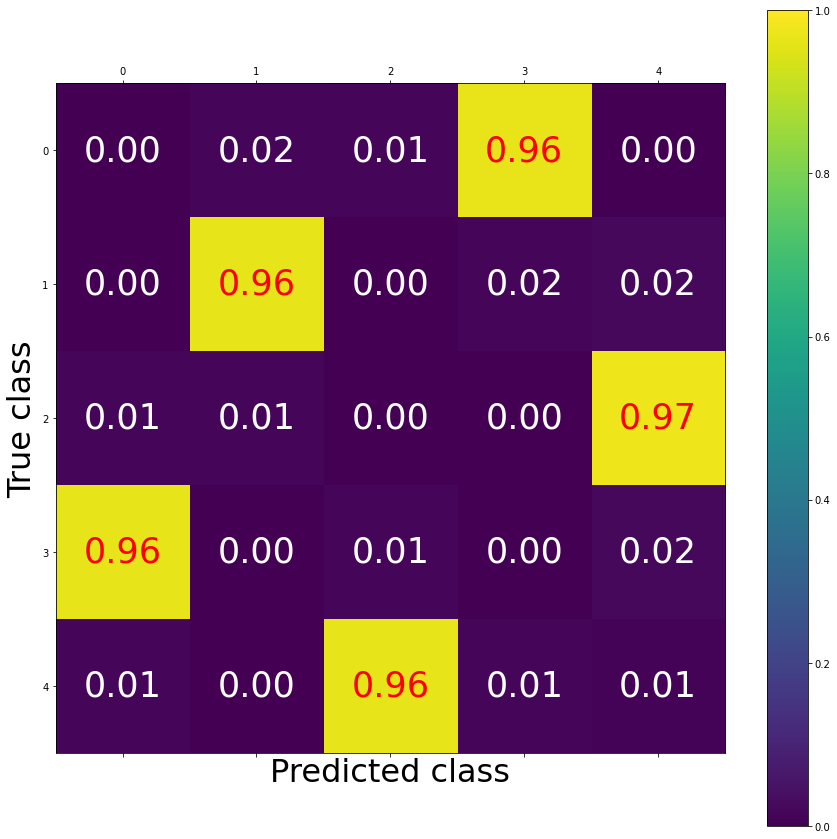

In [32]:
confusion_matrix = np.zeros((N_hyp, N_hyp))
for i_test in range(N_hyp):
    b = generative_model(p_true[:, i_test], N_trials)
    # matching
    k_star = surprise(b, p_hat).argmin(axis=-1)
    for i_hyp in range(N_hyp):
        confusion_matrix[i_test, i_hyp] = (k_star == i_hyp).mean()    

fig, ax = plot_confusion_matrix(confusion_matrix)
plt.show()

Here the predicted class does not correspond necessarily to the true class because the basis are not the same exactly. Same shape and following the generative model, as observed in the figure above, but they can be shifted in the address space.  

# Notebook B - 2020-07-01 B coding and learning from binary inputs-robustness.ipynb
Now that we have a working algorithm, let's evaluate its robustness

In [44]:
from obv1 import evaluate, learn, get_confusion_matrix
N_scan = 15

In [ ]:
sigmas = np.geomspace(.1, 1.4, N_scan)
result_short, result_true, result_hat = [], [], []
for sigma_ in tqdm(sigmas, desc='scanning'):
    result_true.append(evaluate(K, N, sigma_, p1, 0, eta, N_trials))
    result_hat.append(evaluate(K, N, sigma_, p1, N_epochs, eta, N_trials))
    result_short.append(evaluate(K, N, sigma_, p1, N_epochs//10, eta, N_trials))

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.step(sigmas, result_true, label='true', alpha=.8)
ax.step(sigmas, result_hat, label='learned', alpha=.8)
ax.step(sigmas, result_short, label='short learning', alpha=.8)
ax.hlines([1/K, 1.], sigmas.min(), sigmas.max(), linestyles='--')
ax.set_ylabel('perf')
ax.set_xlabel('B_theta')
ax.set_xscale('log')
plt.legend(loc='best')
plt.show()

scanning:   0%|          | 0/15 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/joe/Documents/boulot/git/pyTERtorch/OBV1/obv1.py:15: RuntimeWarning: divide by zero encountered in log2
  return -(b[:, :, None]*np.log2(p[None, :, :]) + (1-b[:, :, None])*np.log2(1-p[None, :, :])).mean(axis=1)
/Users/joe/Documents/boulot/git/pyTERtorch/OBV1/obv1.py:15: RuntimeWarning: invalid value encountered in multiply
  return -(b[:, :, None]*np.log2(p[None, :, :]) + (1-b[:, :, None])*np.log2(1-p[None, :, :])).mean(axis=1)
/Users/joe/Documents/boulot/git/pyTERtorch/OBV1/obv1.py:109: RuntimeWarning: Mean of empty slice.
  p_new = b[k_star==k, :].mean(axis=0)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/joe/Documents/boulot/git/pyTERtorch/OBV1/obv1.py:15: RuntimeWarning: invalid value encountered in log2
  return -(b[:, :, None]*np.log2(p[None, :, :]) + (1-b[:, :, None])*np.log2(1-p[None, :, :])).mean(axis=1)


This shows that the learning closely fits the performance knowing the true patterns. It also shows that the learning fails in the early stage for very peaked distributions.

Let's see how this works as a function of the number of synapses:

In [ ]:
#Ns = [int(_) for _ in N*np.logspace(-1, .2, N_scan, base=10, endpoint=True)]
Ns = [int(_) for _ in N*np.geomspace(.1, 1.3, N_scan)]
print('N in ', Ns)

result_true, result_hat = [], []
for N_ in tqdm(Ns, desc='scanning'):
    result_true.append(evaluate(K, N_, sigma, p1, 0, eta, N_trials))
    result_hat.append(evaluate(K, N_, sigma, p1, N_epochs, eta, N_trials))

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.step(Ns, result_true, label='true')
ax.step(Ns, result_hat, label='learned')
ax.hlines([1/K, 1.], np.array(Ns).min(), np.array(Ns).max(), linestyles='--')
ax.set_ylabel('perf')
ax.set_xlabel('N')
ax.set_xscale('log')
plt.legend(loc='best')
plt.show()

Learning fails when the input vector is not big enough. Performance raises as soon as N >~ 150 to catch "true perf".

We can now scan the other role of average firing rate:

In [ ]:
p1s = p1*np.logspace(-1, .3, N_scan, base=10, endpoint=True)
print('p1 in ', p1s)
result_true, result_hat = [], []
for p1_ in tqdm(p1s, desc='scanning'):
    result_true.append(evaluate(K, N, sigma, p1_, 0, eta, N_trials))
    result_hat.append(evaluate(K, N, sigma, p1_, N_epochs, eta, N_trials))

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.step(p1s, result_true, label='true')
ax.step(p1s, result_hat, label='learned')
ax.hlines([1/K, 1.], np.array(p1s).min(), np.array(p1s).max(), linestyles='--')
ax.set_ylabel('perf')
ax.set_xlabel('p1')
ax.set_xscale('log')
plt.legend(loc='best')
plt.show()

Learning fails when the input gets too sparse - but also when there are too many.

We can now scan the other parameters of the learning:

In [ ]:
etas = eta*np.logspace(-1, 1, N_scan, base=10, endpoint=True)
result_hat = []
for eta_ in tqdm(etas, desc='scanning'):
    result_hat.append(evaluate(K, N, sigma, p1, N_epochs, eta_, N_trials))

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.step(etas, result_hat)
ax.hlines([1/K, 1.], np.array(etas).min(), np.array(etas).max(), linestyles='--')
ax.set_ylabel('perf')
ax.set_xlabel('eta')
ax.set_xscale('log')
plt.show()

In [ ]:
noises = noise*np.logspace(-1, 1, N_scan, base=10, endpoint=True)
result_hat = []
for noise_ in tqdm(noises, desc='scanning'):
    result_hat.append(evaluate(K, N, sigma, p1, N_epochs, eta, noise_, N_trials))

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.step(noises, result_hat)
ax.hlines([1/K, 1.], np.array(noises).min(), np.array(noises).max(), linestyles='--')
ax.set_ylabel('perf')
ax.set_xlabel('noise')
ax.set_xscale('log')
plt.show()

In [ ]:
N_epochss = [int(_) for _ in np.logspace(0, 3, N_scan, base=10, endpoint=True) - 1]
result_hat = []
# TODO cross validation
for N_epochs_ in tqdm(N_epochss, desc='scanning'):
    result_hat.append(evaluate(K, N, sigma, p1, N_epochs_, eta, N_trials))

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.step(N_epochss, result_hat)
ax.hlines([1/K, 1.], np.array(N_epochss).min(), np.array(N_epochss).max(), linestyles='--')
ax.set_ylabel('perf')
ax.set_xlabel('N_epoch')
ax.set_xscale('log')
plt.show()

In [ ]:
Ks = [int(_) for _ in np.arange(7, 7+N_scan)]

result_true, result_hat = [], []
for K_ in tqdm(Ks, desc='scanning'):
    result_true.append(evaluate(K_, N, sigma, p1, 0, eta, N_trials))
    result_hat.append(evaluate(K_, N, sigma, p1, N_epochs, eta, N_trials))

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.step(Ks, result_true, label='true')
ax.step(Ks, result_hat, label='learned')
ax.step(Ks, 1/np.array(Ks), '--', label='chance level')
ax.hlines([1.], np.array(Ks).min(), np.array(Ks).max(), linestyles='--')
ax.set_ylabel('perf')
ax.set_xlabel('K')
#ax.set_xscale('log')
plt.legend(loc='best')
plt.show()

# 2020-07-01 C temporal coding and learning from binary inputs.ipynb
we identified binary patterns in a set of trials. Let's now do this recursively in time and in an online fashion.

In [ ]:
verb= True
N_trials = 2**11
p1 = .01
N = 2**8
K = 7 # number of patterns
sigma = .71 # bandwidth
h = .005 # hazard rate per time bin / gives the integration time as tau = 1 / h

In [ ]:
# chec if missing cells

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width))
ax.pcolormesh(b.T)
ax.set_xlabel('time (ms)')
ax.set_ylabel('input address')
plt.show()

Smoothed firing rate (will be useful later)

In [ ]:
f = np.zeros_like(b*1)
f[0, : ] = p1*np.ones(N)

T, N = b.shape

for t in range(T-1):
    f[t+1, : ] = h * b[t+1, : ] + (1-h) * f[t, : ]
    
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width))
ax.pcolormesh(f.T)
ax.set_xlabel('time')
ax.set_ylabel('input address')
plt.show()

In [ ]:
S = np.zeros((T, N_hyp))
S[0, :] = surprise(p1*np.ones(N)[None, :], p_true)

for t in range(T-1):
    S[t+1, :] = (1-h) * S[t, :] + h * surprise(b[t, : ][None, :], p_true)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(S)
ax.set_xlabel('time')
ax.set_ylabel('NLL')
plt.show()

In [ ]:
from obv1 import get_proba
P = get_proba(S)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(P, alpha=.5)
ax.hlines(1/K, 0, T, linestyles='--')

ax.set_xlabel('time')
ax.set_ylabel('probability')
plt.show()

for fun, we can consider assemblies of 100 neurons generating spikes according to this model:

In [ ]:
N_pop = 100
b_out = np.zeros((T, 0))
for i_test in range(N_hyp):
    b_out = np.hstack((b_out, generative_model(P[:, i_test], N_pop).T))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width))
ax.pcolormesh(b_out.T)
ax.set_xlabel('time')
ax.set_ylabel('output address')
plt.show()

# Other notebooks

In [ ]:
p_hat = np.random.rand(N, N_hyp)
p_hat *= b.mean()/p_hat.mean()
print(f'p_hat.mean() = {p_hat.mean():.3f}')

p_random = np.random.rand(N, N_hyp)
p_random *= b.mean()/p_random.mean()
print(p_random.mean(axis=0))

In [ ]:
from obv1 import learn2 as learn
N_epochs = 500
eta = .0005
alpha = .5

p_hat, P, F, proba_win = learn(p_hat, p_true, h=h, N_epochs=N_epochs, eta=eta, alpha=alpha, N_trials=N_trials)    

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
#ax.plot([0, N_epochs], [F_true, F_true], '--', alpha=.4, lw=2)
ax.step(np.arange(N_epochs), F, alpha=.9)
ax.set_ylabel('surprise')
ax.set_xlabel('epochs')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
#ax.plot([0, N_epochs], [F_true, F_true], '--', alpha=.4, lw=2)
ax.pcolormesh(np.arange(N_epochs), np.arange(K), proba_win.T, alpha=.9)
ax.set_ylabel('Pr_win')
ax.set_xlabel('epochs')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
for i_test in range(N_hyp):
    ax.plot(np.arange(N), p_true[:, i_test], '--', alpha=.4, lw=2)
    ax.step(np.arange(N), p_hat[:, i_test], alpha=.7)
ax.set_ylabel('probability of firing for each address')
ax.set_xlabel('address')
ax.set_xlim(0, N)
plt.show()

In [ ]:
from obv1 import learn3 as learn
N_epochs = 500
eta = .0005
alpha = .5

p_hat, P, F, proba_win = learn(p_hat, p_true, h=h, N_epochs=N_epochs, eta=eta)    

# Online clustering

In [ ]:
from obv1 import OnlineBinaryDetection
bod = OnlineBinaryDetection(opt)

In [ ]:
b = bod.get_data(p_true)
fig, ax = bod.plot_raster(bod.firing_rate(b))
plt.show()

In [ ]:
S = bod.get_surprise(b, p_true)
fig, ax = bod.plot_surprise(S)
plt.show()

In [ ]:
P = bod.get_proba(S)
fig, ax = bod.plot_proba_out(P)
plt.show()

In [ ]:
b_out = bod.get_output(P, N_pop=100)
fig, ax = bod.plot_raster(b_out)
plt.show()

In [ ]:
from obv1 import AdaptiveBinaryClustering
abc = AdaptiveBinaryClustering(opt)

In [ ]:
p_true = abc.stack()
p_hat, P, F, proba_win = abc.learn(p_true)
abc.plot_F(F)
plt.show()

In [ ]:
fig, ax = abc.plot_P_win(proba_win)
plt.show()
print('proba_win * K =', proba_win[-1, :] * abc.opt.K)

In [ ]:
abc.plot_p_hat(p_true, p_hat)
plt.show() 

In [ ]:
b_out = abc.get_output(P, N_pop=100)
fig, ax = abc.plot_raster(b_out)
plt.show()

- 2020-07-04 A temporal coding and learning_HL.ipynb
- 2020-07-04 A temporal coding and learning_LP2.ipynb
- 